2.3 基于技术的方法

基于Python的语料库预处理

In [86]:
text='You say goodbye and I say hello.'
text=text.lower()   #lower函数实现将所有字母转为小写
text=text.replace('.',' .')  #通过split切分句子
print(text)
words=text.split(' ')
print(words)

you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [73]:
#s使用字典创建单词ID和单词对应表
word_to_id={}
id_to_word={}

for word in words:
    if word not in word_to_id:
        new_id=len(word_to_id)
        word_to_id[word]=new_id  #id号
        id_to_word[new_id]=word    #单词
print(word_to_id)
print(id_to_word)

print(id_to_word[1])
print(word_to_id['hello'])

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
say
5


In [74]:
#将单词列表转为单词ID列表
import numpy as np
corpus=[word_to_id[w] for w in words]  #形式为列表解析式|字典解析式
corpus=np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


In [118]:
#封装为process()函数
def process(text):
    text=text.lower()
    text=text.replace('.',' .')
    words=text.split(' ')
    
    word_to_id={}
    id_to_word={}
    
    for word in words:
        if word not in word_to_id:
            new_id=len(word_to_id)
            word_to_id[word]=new_id
            id_to_word[new_id]=word
    
    corpus=np.array([word_to_id[w] for w in words])
    return corpus,word_to_id,id_to_word
#corpus是单词ID列表，word_to_ID是单词到单词ID列表，ID_to_word是单词ID到单词列表

In [92]:
text='You say goodbye and I say hello.'
corpus,word_to_id,id_to_word=process(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


共现矩阵的实现

In [77]:
import numpy as np
def create_co_matrix(corpus,vacb_size,window_size=1):
    corpus_size=len(corpus)
    co_matrix=np.zeros((vacb_size,vacb_size),dtype=np.int32)
    
    for idx,word_id in enumerate(corpus):#enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。
        for i in range(1,window_size+1):  #遍历某个单词左右两侧滑动窗口内的单词情况
            left_idx=idx-i  #某个单词左侧的索引位置
            right_idx=idx+i #某个单词右边的索引位置
            
            if left_idx>=0:
                left_word_id=corpus[left_idx]   #此时滑动窗口左侧元素的ID
                co_matrix[word_id,left_word_id]+=1   #此时共现矩阵对应位置的值变为1
            
            if right_idx<corpus_size:
                right_word_id=corpus[right_idx]
                co_matrix[word_id,right_word_id]+=1
        
    return co_matrix

In [78]:
print(create_co_matrix(corpus,len(corpus)-1,window_size=1))

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


余弦相似度的实现

In [119]:
def cos_similarity(x,y,eps=1e-8):
    nx=x/(np.sqrt(np.sum(x**2))+eps)
    ny=y/(np.sqrt(np.sum(y**2))+eps)
    return np.dot(nx,ny)

In [120]:
C=create_co_matrix(corpus,len(corpus)-1)
C0=C[word_to_id['you']]
C1=C[word_to_id['i']]
print(cos_similarity(C0,C1))

0.7071067691154799


相似单词的排序

In [121]:
def most_similar(query,word_to_id,id_to_word,cos_matrix,top=5):#输出与某个单词最相似的单词和余弦相似度
    #取出查询词
    if query not in word_to_id:
        print('%s is not found!',query)
        return 
    print('\n[query] '+query)
    query_id=word_to_id[query]
    query_vec=cos_matrix[query_id]
    
    #计算余弦相似度
    vocab_size=len(id_to_word)
    similarity=np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i]=cos_similarity(cos_matrix[i],query_vec)
    
    #基于余弦相似度，按降序输出值
    count=0
    for i in (-1*similarity).argsort():  #argsort()返回的是数组的索引
        if id_to_word[i]==query:
            continue
        print(' %s: %s' %(id_to_word[i],similarity[i]))
        
        count+=1
        if count>=top:
            return

In [122]:
vocab_size=len(word_to_id)
#print(vocab_size)
C=create_co_matrix(corpus,vocab_size)
#print(C)
print(most_similar('you',word_to_id,id_to_word,C,top=5))


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0
None


将共现矩阵转为PPMI

In [123]:
import numpy as np
def PPMI(C,verbose=False,eps=1e-8):  #verbose是决定是否输出运行情况的标志,为了防止np.log2(0)=-inf使用了微小值eps
    M=np.zeros_like(C,dtype=np.float32)  #M矩阵是PPMI最后得出的矩阵
    N=np.sum(C)   #转为一维数组
    S=np.sum(C,axis=0)
    total=C.shape[0]*C.shape[1]   #C.shape[0]=7,C.shape[1]=7
    cnt=0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):   #遍历原矩阵，计算每个元素对应位置的PPMI矩阵元素的值
            pmi=np.log2(C[i,j]*N/(S[i]*S[j])+eps)
            M[i,j]=max(0,pmi)
            
            if verbose:
                cnt+=1
                if cnt%(total//100+1)==0:
                    print('%.1f%% done' %(100*cnt/total))
    return M

In [124]:
W=PPMI(C)
print("The covariance matrix is:")
print(C)
print("######################################################################################")
print("The PPMI matrix is:")
print(W)

The covariance matrix is:
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
######################################################################################
The PPMI matrix is:
[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


2.4 降维（找轴）

奇异值分解SVD

In [113]:
#直接使用numpy中的linalg模块中的svd方法进行转换
U,S,V = np.linalg.svd(W)

In [114]:
print(C[0])
print(W[0])
print(U[0])

[0 1 0 0 0 0 0]
[0.        1.8073549 0.        0.        0.        0.        0.       ]
[ 3.4094876e-01  0.0000000e+00 -1.2051624e-01 -3.3306691e-16
 -9.3232495e-01 -1.1102230e-16 -2.4257469e-17]


In [115]:
#通过SVD将稀疏矩阵转为密集型矩阵，若对密集型矩阵降维，则只需降维到二维向量，取出前两个元素
print(U[0, :2])

[0.34094876 0.        ]


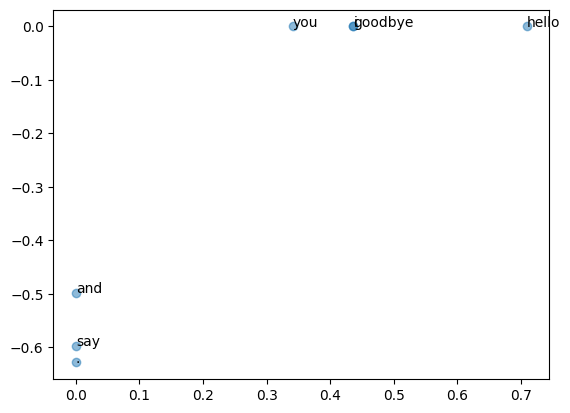

In [117]:
#用二维向量表示各个单词，画图
import matplotlib.pyplot as plt
for word,word_id in word_to_id.items():
    plt.annotate(word,(U[word_id,0],U[word_id,1]))  #annotate用于标注文字
plt.scatter(U[:,0],U[:,1],alpha=0.5)
plt.show()